## Create RGB Visualization 
We visualize the PACE spectra into a video instead of a single map

### 1. Remote Sensing Reflection (Rrs) of a single date

In [2]:
#Login to earthdata
import earthaccess
import xarray as xr
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

    

In [8]:
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_SFREFL',
    temporal = ("2024-03-01", "2024-03-31"), #use larger memory to avoid crash
    granule_name="*.MO.*.4km.*"
)
fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[0])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# We can open all the files but note there is no time coordinate so we need
# combine="nested" and concat_dim
ds = xr.open_mfdataset(
    fileset,
    combine="nested",
    concat_dim="time")
ds

<xarray.Dataset> Size: 18GB
Dimensions:     (time: 1, lat: 4320, lon: 8640, wavelength: 122, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * wavelength  (wavelength) float64 976B 346.0 351.0 ... 2.131e+03 2.258e+03
Dimensions without coordinates: time, rgb, eightbitcolor
Data variables:
    rhos        (time, lat, lon, wavelength) float32 18GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 768B dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.SFRE...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/SFREFL/3.1
    data_bins:                         31469390
    data_minimum:                      -0.049858075
    data_maximum:                      1.5

/tmp/ipykernel_3390/1597591987.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


['id', 'x', 'y']


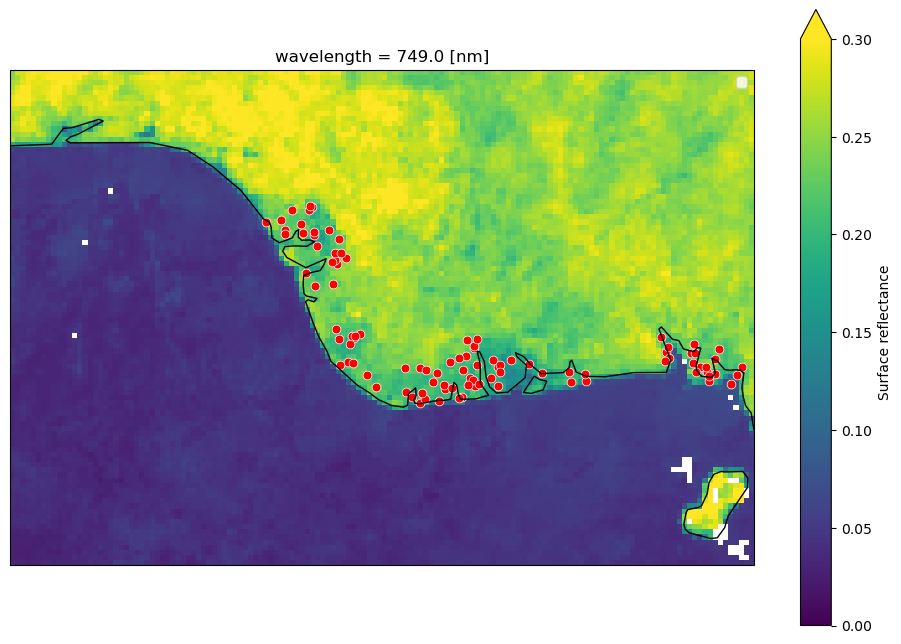

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


# Niger delta bounds: (lat_max, lat_min, lon_min, lon_max)
ds1=ds
ds_nigdelta = ds1.sel(
    lat=slice(7, 3), 
    lon=slice(3, 9)
)

#use wavelength of 1125 based on the spectral characteristic above
Rrs_ds = ds_nigdelta["rhos"].sel(wavelength=750.0, method="nearest")

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
Rrs_ds.plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=0.3)
ax.coastlines(resolution="50m")

ax.legend(loc="upper right")


import pandas as pd

# Load ship data
points_df = pd.read_csv("/home/jovyan/2026-proj-blue-carbon/data/extracted_mangrove/mangrove_points.csv")
print(points_df.columns.tolist())
points_df
ax.scatter(points_df["x"], points_df["y"], s=40, c="red", edgecolor="white", linewidth=0.5, label="Stations")


plt.show()

In [ ]:
Rrs_ds = ds_nigdelta["rhos"]


In [ ]:
print(Rrs_ds.dims)
# ('time', 'wavelength', 'lat', 'lon')  or ('wavelength', 'lat', 'lon')


In [ ]:
# decide min max
vmin = float(Rrs_ds.min())
vmax = float(Rrs_ds.max())


In [ ]:
#create gif
import imageio
import os
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

frames = []
tmp_dir = "frames_wavelength2"
os.makedirs(tmp_dir, exist_ok=True)

for wl in Rrs_ds.wavelength.values:
    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    Rrs_ds.sel(wavelength=wl).plot(
        ax=ax,
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True
    )

    ax.coastlines(resolution="50m")

    ax.scatter(
        points_df["x"],
        points_df["y"],
        s=40,
        c="red",
        edgecolor="white",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
        label="Stations"
    )

    ax.set_title(f"Rrs | {int(wl)} nm")

    fname = f"{tmp_dir}/wl_{int(wl)}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.close()

    frames.append(imageio.imread(fname))


In [ ]:
imageio.mimsave(
    "rrs_spectral_scan.gif",
    frames,
    duration=0.4
)


### 2. multiple wavelength in an RGB

In [ ]:
#Preparation
Rrs = ds_nigdelta["rhos"]

# optional but recommended
#Rrs = Rrs.mean("time")

# sort wavelengths
Rrs = Rrs.sortby("wavelength")


In [ ]:
#define wavelength range
wls = Rrs.wavelength.values

# valid starting wavelengths
wl_start = wls[wls + 100 <= wls.max()]


In [ ]:
#color config
vmin, vmax = 0.0, 0.3


In [ ]:
#normalization
import numpy as np

def norm(x, vmin, vmax):
    x = np.clip(x, vmin, vmax)
    return (x - vmin) / (vmax - vmin)


In [ ]:
import imageio
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

frames = []
tmp_dir = "frames_rgb2"
os.makedirs(tmp_dir, exist_ok=True)

for wl in wl_start:
    r = Rrs.sel(wavelength=wl, method="nearest")
    g = Rrs.sel(wavelength=wl + 50, method="nearest")
    b = Rrs.sel(wavelength=wl + 100, method="nearest")

    rgb = np.dstack([
        norm(r.values, vmin, vmax),
        norm(g.values, vmin, vmax),
        norm(b.values, vmin, vmax)
    ])

    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    ax.imshow(
        rgb,
        extent=[
            Rrs.lon.min(), Rrs.lon.max(),
            Rrs.lat.min(), Rrs.lat.max()
        ],
        origin="upper",
        transform=ccrs.PlateCarree()
    )

    ax.coastlines(resolution="50m")

    ax.scatter(
        points_df["x"],
        points_df["y"],
        s=40,
        c="white",
        edgecolor="black",
        linewidth=0.5,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(
        f"RGB composite | R={int(wl)} G={int(wl+50)} B={int(wl+100)} nm"
    )

    fname = f"{tmp_dir}/rgb_{int(wl)}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.close()

    frames.append(imageio.imread(fname))


In [ ]:
imageio.mimsave(
    "pace_rgb_spectral_sweep.gif",
    frames,
    duration=0.5
)